In [3]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
import catboost
import optuna
matplotlib.rcParams['font.family']='IPAGothic'

In [4]:
def cv_generator():
    base_path = "../../data/std_data/"
    for year in range(1978, 2020):
        train_x = pd.read_pickle(base_path + "train/{}_x.pkl".format(year)).values
        test_x = pd.read_pickle(base_path + "test/{}_x.pkl".format(year)).values
        train_y = pd.read_pickle(base_path + "train/{}_y.pkl".format(year)).values
        test_y = pd.read_pickle(base_path + "test/{}_y.pkl".format(year)).values
        yield (train_x, train_y, test_x, test_y)

In [5]:
def objective(trial):
    #paramter_tuning using optuna
    params = {
        'iterations' : trial.suggest_int('iterations', 50, 1000),                         
        'depth' : trial.suggest_int('depth', 1, 10),                                       
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),               
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }
        
    model = catboost.CatBoostRegressor(**params, logging_level='Silent')
        
    pred_y_all = np.array([])
    y_true_all = np.array([])
    
    data_gen = cv_generator()
    
    for (train_x, train_y, test_x, test_y) in data_gen:
        model.fit(train_x, train_y)
        pred_y = model.predict(test_x)
        pred_y_all = np.hstack((pred_y_all, pred_y))
        y_true_all = np.hstack((y_true_all, test_y))
        
    fpr, tpr, thresholds = metrics.roc_curve(y_true_all, pred_y_all, pos_label=1)
    
    return metrics.auc(fpr, tpr)

In [ ]:
def main():
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

    print('Number of finished trials: {}'.format(len(study.trials)))

    print('Best trial:')
    trial = study.best_trial

    print('  Value: {}'.format(trial.value))

    print('  Params: ')
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))

main()

auc: 0.6191885038038883


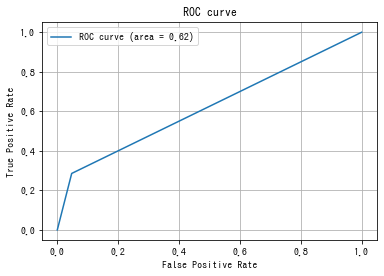

In [18]:
import matplotlib.pyplot as plt
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(test_ys, predicted_ys)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

print("auc: {}".format(auc))

## GridSearch